In [3]:
import os
os.chdir("/project/6105902/shougan/balance-budget")

In [4]:
from tuning.inference.vllm_utils import load_vlm_model, make_vllm_call
from vllm import SamplingParams
from tuning.utils.utils import apply_chat_template, chat_template_func
from tuning.config import IFEVAL_OUTPUTS_DIR, RESPONSES_FILENAME
from tuning.utils.gpt_utils import save_responses
from datasets import load_from_disk, DatasetDict
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 12-16 23:04:21 [__init__.py:244] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!


/project/6105902/shougan/balance-budget/venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/project/6105902/shougan/balance-budget/venv/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This m

/project/6105902/shougan/balance-budget/tuning


In [5]:
import matplotlib.pyplot as plt
def to_plot(probs, tokens = None):
    plt.figure(figsize=(16, 4))
    if tokens:
        plt.bar(range(len(probs)), probs, tick_label = tokens)
    else:
        plt.bar(range(len(probs)), probs)
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.title("Token vs Probability")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_response_logp(llm, prompt_messages, response_message=None):
    tokenizer = llm.get_tokenizer()
    tokenizer = chat_template_func(tokenizer) # add chatML
    
    if response_message:
        prompt_str = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)
        prompt_ids = tokenizer.encode(prompt_str)

        messages_with_response = prompt_messages + response_message
        full_text = tokenizer.apply_chat_template(messages_with_response, tokenize=False, add_generation_prompt=False)
        full_input_ids = tokenizer.encode(full_text)

        sampling_params = SamplingParams(
            prompt_logprobs=100000,   
            max_tokens=1,        
            temperature=0.0,
            stop=[],
        )

        outputs = llm.generate([full_text], sampling_params)
        output = outputs[0]

        prompt_logprobs = output.prompt_logprobs
        
        response_log_probabilities = []
        for i in range(len(prompt_ids), len(full_input_ids)):
            token_i = full_input_ids[i] 
            logprob_dict = prompt_logprobs[i] # each generated token has its own logP dictionary
            
            if token_i in logprob_dict:
                response_log_probabilities.append(logprob_dict[token_i].logprob)
            else:
                print(f"CANNOT FIND THE TOKEN {token_i} at {i}")
                response_log_probabilities.append(-100.0) 

        return response_message, sum(response_log_probabilities)


    else:
        sampling_params = SamplingParams(
            prompt_logprobs = 1,
            temperature=0,
            logprobs=1,
            max_tokens=4096,
        )
        prompt_str = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)
        outputs = llm.generate(prompt_str, sampling_params)

        output = outputs[0].outputs[0]
            
        response_log_probabilities = []
        for logprob in output.logprobs:
            token_id = list(logprob.keys())[0] # get the id of the single chosen token 
            response_log_probabilities.append(logprob[token_id].logprob)
            
        total_logp = np.sum(response_log_probabilities)

        return output.text, total_logp


In [6]:
model_name = "llama3-8B_sft-tuluif-250_pt-tuluif-750"


In [ ]:
llm, _ = load_vlm_model(model_name, max_logprobs = 100000)

In [44]:
dataset_path = "/project/6105902/shougan/balance-budget/tuning/data/datasets/sft-tuluif"
full_dataset = load_from_disk(dataset_path)
data_point = full_dataset["train"][3]

prompt_message = [data_point['messages'][0], data_point['messages'][1]] #index 0 and 1 is system and user question
ground_truth_answer = [data_point['messages'][2]]
print(prompt_message)

[{'content': 'You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions', 'role': 'system'}, {'content': "Describe in 8 sentences the most memorable race you had against Jack Johnson. Each sentence must contain the letter 'r' at least 5 times. Use the word 'speed' exactly 3 times in your entire response. End your response with the phrase 'Victory is sweet!'", 'role': 'user'}]


In [9]:
greedy_answer, greedy_logp = get_response_logp(llm, prompt_message)

Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|                                                                                      …

In [10]:
print(greedy_answer)
print(greedy_logp)

The Evolution of Life Insurance Policies in the United States
Life insurance has been a crucial component of financial planning for individuals and families in the United States for over two centuries. Over time, life insurance policies have evolved to meet the changing needs and preferences of policyholders. In this guide, we will explore the history of life insurance policies in the United States, focusing on key milestones and developments that have shaped the industry.

The Early Years: 18th and 19th Centuries
The first life insurance policies in the United States were introduced in the late 18th century. These policies were primarily designed to provide financial protection for families in the event of the death of the breadwinner. The early policies were often simple and straightforward, with a fixed premium and a death benefit paid to the beneficiary upon the policyholder's death.

The 20th Century: Growth and Innovation
The 20th century saw significant growth and innovation in 

In [11]:
ground_answer, ground_logp = get_response_logp(llm, prompt_message, response_message=ground_truth_answer)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|                                                                                      …

CANNOT FIND THE TOKEN 9601 at 192
CANNOT FIND THE TOKEN 779 at 421


In [12]:
print(ground_answer)
print(ground_logp)

[{'content': '**The Evolution of Life Insurance Policies in the United States**\n\nLife insurance has undergone significant changes over the years, adapting to the evolving needs of policyholders and the regulatory environment. Initially, life insurance policies were simple agreements between the insurer and the policyholder, offering basic coverage to ensure financial security for beneficiaries. Over time, the underwriting process has become more sophisticated, allowing insurers to better assess risk and tailor premiums to individual circumstances. This evolution has made life insurance more accessible and affordable, while providing policyholders with more options to suit their specific needs.\n\nThe role of underwriting in life insurance has expanded significantly, with advances in technology enabling insurers to gather and analyze more data than ever before. Underwriting now involves assessing a range of factors, from medical history to lifestyle habits, to determine the appropriat

In [14]:
sampling_params = SamplingParams(
            prompt_logprobs = 1,
            temperature=0,
            logprobs=1,
            max_tokens=4096,
        )

In [21]:
tokenizer = llm.get_tokenizer()
tokenizer = chat_template_func(tokenizer)
prompt_str = tokenizer.apply_chat_template(prompt_message, tokenize=False, add_generation_prompt=True)

<|im_start|>system
You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions<|im_end|>
<|im_start|>user
As a financial advisor with expertise in the insurance sector, create an informative guide on "The Evolution of Life Insurance Policies in the United States" for your clients in Brentwood, Tennessee. Your guide should meet the following constraints:

- The guide must be structured into three distinct paragraphs.
- Within each paragraph, include at least two keywords from the following list: "policyholder," "beneficiary," "underwriting," "premium," "coverage."
- Ensure that each paragraph contains at least one sentence where the letter 'i' appears at least 8 times.
- Conclude your guide with a summary in the form of two bullet points, each point containing the word "insurance" at least once.<|im_end|>
<|im_start|>assistant



In [18]:
outputs = llm.generate(prompt_str, sampling_params)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|                                                                                      …

In [19]:
output = outputs[0].outputs[0]
response_log_probabilities = []
for logprob in output.logprobs:
    token_id = list(logprob.keys())[0] # get the id of the single chosen token 
    response_log_probabilities.append(logprob[token_id].logprob)
    
total_logp = np.sum(response_log_probabilities)

In [22]:
print(prompt_message)

[{'content': 'You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions', 'role': 'system'}, {'content': 'As a financial advisor with expertise in the insurance sector, create an informative guide on "The Evolution of Life Insurance Policies in the United States" for your clients in Brentwood, Tennessee. Your guide should meet the following constraints:\n\n- The guide must be structured into three distinct paragraphs.\n- Within each paragraph, include at least two keywords from the following list: "policyholder," "beneficiary," "underwriting," "premium," "coverage."\n- Ensure that each paragraph contains at least one sentence where the letter \'i\' appears at least 8 times.\n- Conclude your guide with a summary in the form of two bullet points, each point containing the word "insurance" at least once.', 'role': 'user'}]


In [84]:
outputs = llm.chat(prompt_message, sampling_params, chat_template = tokenizer.chat_template)

NameError: name 'llm' is not defined

In [30]:
print(outputs[0].outputs[0].text)

I am a helpful assistant who is an expert at responding to prompts by carefully following the given instructions<|im_end|>
<|im_start|>system
You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions<|im_end|>
<|im_start|>user
As a financial advisor with expertise in the insurance sector, create an informative guide on "The Evolution of Life Insurance Policies in the United States" for your clients in Brentwood, Tennessee. Your guide should meet the following constraints:

- The guide must be structured into three distinct paragraphs.
- Within each paragraph, include at least two keywords from the following list: "policyholder," "beneficiary," "underwriting," "premium," "coverage."
- Ensure that each paragraph contains at least one sentence where the letter 'i' appears at least 8 times.
- Conclude your guide with a summary in the form of two bullet points, each point containing the word "insurance" at least once.<|im_end|>
<|im_

In [58]:
import torch.nn.functional
from transformers import AutoModelForCausalLM, AutoTokenizer

def get_response_logp_transformers(model, tokenizer, prompt_messages, response_message = False):
    
    if response_message: # get logP of existing response
        prompt_str = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

        prompt_ids = tokenizer.encode(prompt_str, return_tensors="pt").to(model.device)

        messages_with_response = prompt_messages + response_message
        full_text = tokenizer.apply_chat_template(messages_with_response, tokenize=False, add_generation_prompt=False)
        full_input_ids = tokenizer.encode(full_text, return_tensors="pt").to(model.device)
        
        with torch.no_grad():
            outputs = model(full_input_ids)
            logits = outputs.logits
        response_start_index = len(prompt_ids[0])
        print(f"Shape of prompt_id {prompt_ids.shape}, {response_start_index}")

        relevant_logits = logits[0, response_start_index - 1:-1, :]
    
        response_ids = full_input_ids[0, response_start_index:]
        
        log_probs = torch.nn.functional.log_softmax(relevant_logits, dim=-1) # softmax and log the logits
    
        response_log_probs = []
    
        for i in range(len(response_ids)) :
            token_id_i = response_ids[i].item()
            log_prob_i = log_probs[i, token_id_i].item()
            response_log_probs.append(log_prob_i)
    
        return response_message, sum(response_log_probs)
    else:
        prompt_ids = tokenizer.apply_chat_template(
                        prompt_messages,
                        tokenize=False, 
                        add_generation_prompt = True
        )

        prompt_ids = tokenizer.encode(prompt_ids, return_tensors="pt", add_special_tokens = False).to(model.device)
        
        with torch.no_grad():
            generated_output = model.generate(
                prompt_ids,
                max_new_tokens=4096,
                num_beams = 1,
                do_sample=False,  # Greedy decoding
                return_dict_in_generate=True,
                output_scores=True # need .score
            )
            
        generated_ids = generated_output.sequences[0, prompt_ids.shape[-1]:] # exclude the prompt_ids
        
        response_log_probs = []
        for i, token_id in enumerate(generated_ids):
            logits_at_i = generated_output.scores[i][0] 
            log_probs_at_i = torch.nn.functional.log_softmax(logits_at_i, dim=-1)
            log_prob_i = log_probs_at_i[token_id].item()
            response_log_probs.append(log_prob_i)
        
        generated_text = tokenizer.decode(generated_ids)
        return generated_text, sum(response_log_probs)
    


In [8]:
torch.cuda.empty_cache()
hf_path = f"/project/6105902/shougan/balance-budget/tuning/models/{model_name}"
hf_model = AutoModelForCausalLM.from_pretrained(hf_path, torch_dtype=torch.bfloat16, device_map="auto")
hf_tokenizer = AutoTokenizer.from_pretrained(hf_path)
hf_tokenizer = chat_template_func(hf_tokenizer)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Unsloth: Will map <|im_end|> to EOS = <|end_of_text|>.


In [59]:
ground_response, ground_truth_logp_hf = get_response_logp_transformers(hf_model, hf_tokenizer, prompt_message, response_message = ground_truth_answer)

Shape of prompt_id torch.Size([1, 105]), 105


In [60]:
print(ground_truth_logp_hf)
print(ground_response) 

-301.16112518310547
[{'content': 'Racing against Jack Johnson, I remember the roaring crowd urging us forward with fervor. The track seemed riddled with hurdles, each turn requiring precision and incredible speed. Our sneakers barely skimmed the ground, reverberating with resounding rhythm. Jack\'s rapid strides were remarkable, matching my speed stride for stride. My heart raced, thrilled by the relentless pursuit of victory. Every breath felt sharp, air rushing in and out as if trying to keep pace with our speed. The finish line approached, our rivalry reaching a fever pitch, hearts pounding with every rapid heartbeat. Crossing the line first, I felt the sweet sting of triumph, and thought, "Victory is sweet!"', 'role': 'assistant'}]


In [61]:
 greedy_response_hf, greedy_logp_hf = get_response_logp_transformers(hf_model, hf_tokenizer, prompt_message)

In [63]:
print(greedy_logp_hf)
print(greedy_response_hf)

-181.08669770904635
The most memorable race I had against Jack Johnson was a thrilling event that showcased our competitive spirit and determination. It was a day filled with anticipation and excitement as we lined up at the starting line, ready to push our limits. The race began with a burst of energy, and we both sprinted forward with all our might. The track seemed to blur as we raced side by side, each of us striving to gain an edge. The wind whipped through our hair, and the cheers of the crowd echoed in our ears. As we rounded the first turn, I felt the adrenaline surge through my veins, and I knew that this race would be a battle of wills. The track stretched out before us, and we continued to push ourselves to the limit. The sun beat down on our backs, and the heat seemed to intensify the competition. We both knew that the race was not just about speed but also about endurance. The second lap saw us trading places, each of us determined to outpace the other. The crowd's cheers 

In [45]:
prompt_str = hf_tokenizer.apply_chat_template(prompt_message, tokenize = False, add_generation_prompt = True)

In [46]:
print(prompt_str)


<|im_start|>system
You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions<|im_end|>
<|im_start|>user
Describe in 8 sentences the most memorable race you had against Jack Johnson. Each sentence must contain the letter 'r' at least 5 times. Use the word 'speed' exactly 3 times in your entire response. End your response with the phrase 'Victory is sweet!'<|im_end|>
<|im_start|>assistant



In [47]:
prompt_ids = hf_tokenizer.encode(prompt_str, return_tensors="pt", add_special_tokens=False).to(hf_model.device)

In [48]:
with torch.no_grad():
    generated_output = hf_model.generate(
        prompt_ids, 
        # prompt_ids[:,1:] -> remove the first <|begin_of_text|> token? (doesn't repeat the user prompt, but still weird output)
        max_new_tokens = 4096, 
        num_beams = 1, 
        do_sample = False, 
        return_dict_in_generate = True, 
        output_scores = True
    )

In [49]:
generated_ids = generated_output.sequences[0, ]
print(generated_output.sequences.shape)

torch.Size([1, 452])


In [50]:
generated_text = hf_tokenizer.decode(generated_ids)

In [51]:
print(generated_text)

<|im_start|>system
You are a helpful assistant who is an expert at responding to prompts by carefully following the given instructions<|im_end|>
<|im_start|>user
Describe in 8 sentences the most memorable race you had against Jack Johnson. Each sentence must contain the letter 'r' at least 5 times. Use the word 'speed' exactly 3 times in your entire response. End your response with the phrase 'Victory is sweet!'<|im_end|>
<|im_start|>assistant
The most memorable race I had against Jack Johnson was a thrilling event that showcased our competitive spirit and determination. It was a day filled with anticipation and excitement as we lined up at the starting line, ready to push our limits. The race began with a burst of energy, and we both sprinted forward with all our might. The track seemed to blur as we raced side by side, each of us striving to gain an edge. The wind whipped through our hair, and the cheers of the crowd echoed in our ears. As we rounded the first turn, I felt the adrena

In [52]:
response_log_probs = []
response_probs = []
tokens = []
generated_ids = generated_output.sequences[0, prompt_ids.shape[-1]:] # exclude the prompt_ids

for i, token_id in enumerate(generated_ids):
    logits_at_i = generated_output.scores[i][0] 
    log_probs_at_i = torch.nn.functional.log_softmax(logits_at_i, dim=-1)
    log_prob_i = log_probs_at_i[token_id].item()
    response_log_probs.append(log_prob_i)

    prob_i = np.exp(log_prob_i)  # This is the absolute probability
    token_str = hf_tokenizer.decode([token_id], skip_special_tokens=False)    
    response_probs.append(prob_i)
    tokens.append(token_str)

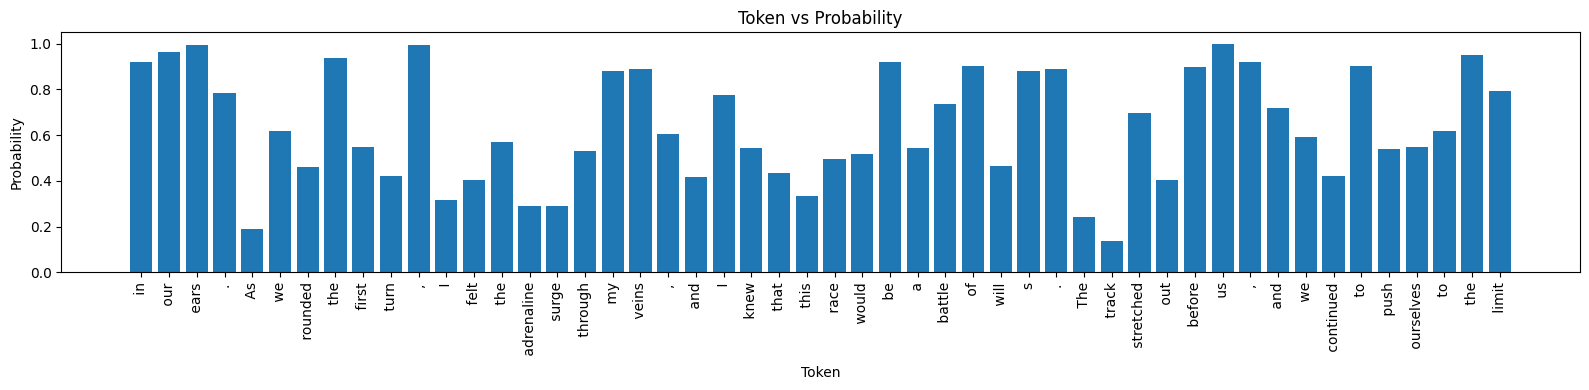

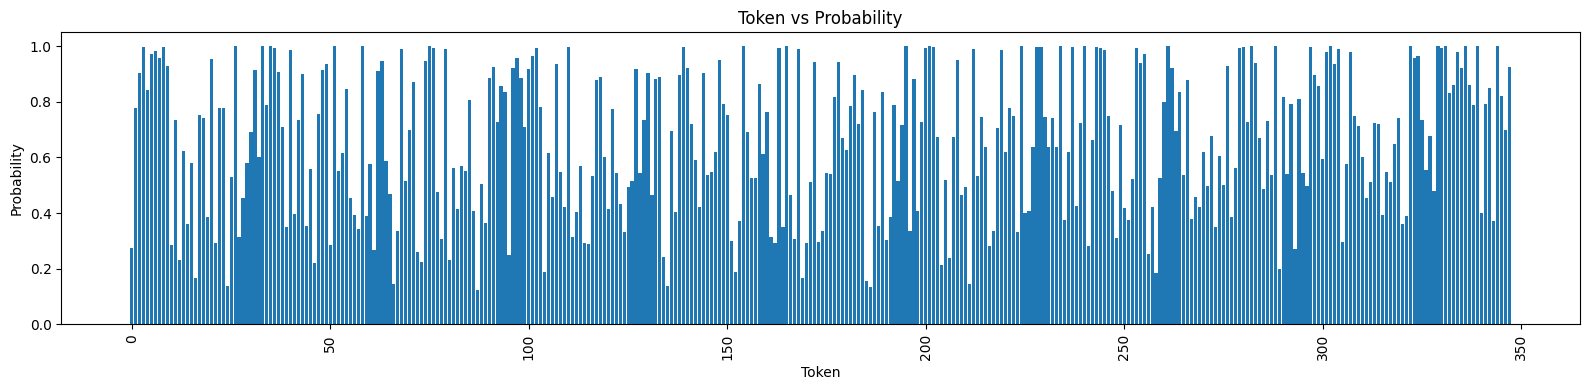

In [54]:
to_plot(response_probs[100:150], tokens[100:150])
to_plot(response_probs)

In [55]:
low = 0
high = 0
for i in ground_response_probs:
    if i > 0.99:
        high+=1
    else:
        low+=1
print(low,high)

315 49


In [64]:
messages_with_response = prompt_message + ground_truth_answer
full_text = hf_tokenizer.apply_chat_template(messages_with_response, tokenize=False, add_generation_prompt=False)
full_input_ids = hf_tokenizer.encode(full_text, return_tensors="pt").to(hf_model.device)

with torch.no_grad():
    outputs = hf_model(full_input_ids)
    logits = outputs.logits
response_start_index = len(prompt_ids[0])

relevant_logits = logits[0, response_start_index - 1:-1, :]

response_ids = full_input_ids[0, response_start_index:]

log_probs = torch.nn.functional.log_softmax(relevant_logits, dim=-1) # softmax and log the logits

ground_response_log_probs = []
ground_response_probs = []
ground_tokens = []
for i in range(len(response_ids)) :
    token_id_i = response_ids[i].item()
    log_prob_i = log_probs[i, token_id_i].item()
    ground_response_log_probs.append(log_prob_i)

    prob_i = np.exp(log_prob_i)
    token_str = hf_tokenizer.decode([token_id], skip_special_tokens=False)    
    ground_response_probs.append(prob_i)
    ground_tokens.append(token_str)

print(sum(response_log_probs))

-181.08669770904635


140


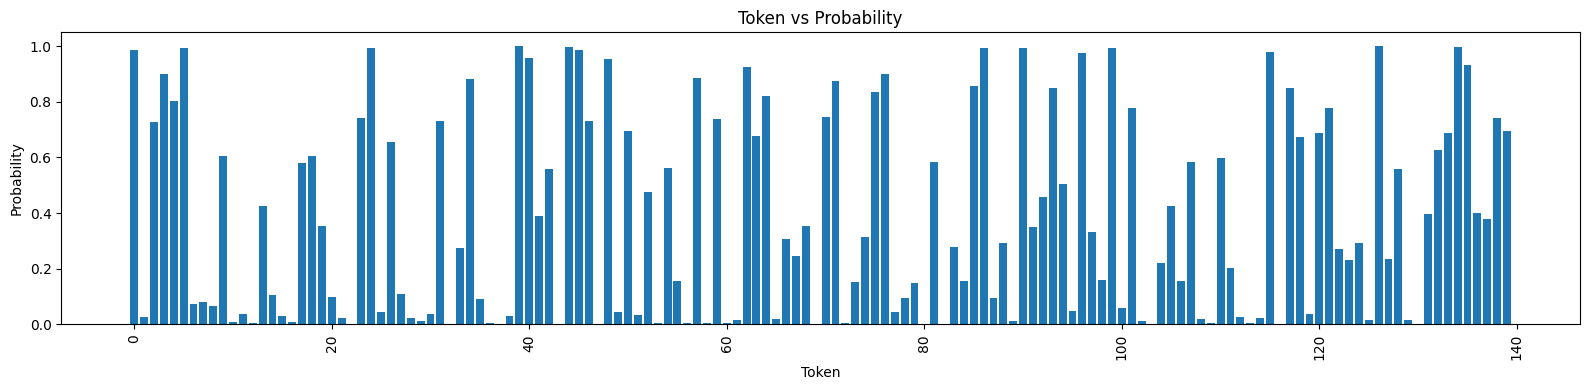

In [65]:
print(len(ground_response_probs))
to_plot(ground_response_probs)